<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/MLP_Fmnist_Saver_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

11501568/11490434 [==============================] - 1s 0us/step


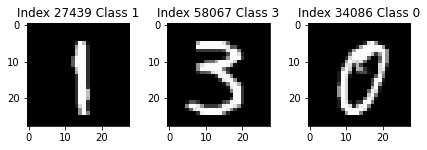

In [13]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [14]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [15]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [16]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [23]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None,keep_prob=0.0,use_l1=False,use_l2=False,use_cusOP=False):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device, self.keep_prob,self.use_l1,self.use_l2,self.use_cusOP=\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device,keep_prob,use_l1,use_l2,use_cusOP
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]


    self.alpha, self.beta_1, self.beta_2, self.beta_3, self.epslion = 1e-4, 0.9, 0.999, 0.999987, 10e-8

    m_list=[]
    v_list=[]
    u_list=[]
    for var in self.variables:
      m_list.append(tf.Variable(tf.zeros_like(var)))
      v_list.append(tf.Variable(tf.zeros_like(var)))
      u_list.append(tf.Variable(tf.zeros_like(var)))
    self.m=m_list
    self.v=v_list
    self.u=u_list
    self.t=0
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    l1=tf.keras.regularizers.L1(l1=2e-5)
    l2=tf.keras.regularizers.L2(l2=2e-5)
    L1=l1(self.W1) + l1(self.W2)+l1(self.W3)+l1(self.W4)
    L2=l2(self.W1) + l2(self.W2)+l2(self.W3)+l2(self.W4)

    if self.use_l1:
      loss_x=loss_x+L1
    if self.use_l2:
      loss_x=loss_x+L2
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    if self.use_cusOP:
      self.t+=1
      for i in range(len(grads)):
        m = self.beta_1*self.m[i]+ (1 - self.beta_1)*grads[i]
        self.m[i].assign(m)
        v = self.beta_2*self.v[i]+ (1 - self.beta_2)*(grads[i]**2)
        self.v[i].assign(v)
        u = self.beta_3*self.u[i]+ (1 - self.beta_3)*(grads[i]**3)
        self.u[i].assign(u)

        mt = tf.math.divide(m, 1 - self.beta_1**self.t)
        vt = tf.math.divide(v, 1 - self.beta_2**self.t)
        ut = tf.math.divide(u, 1 - self.beta_3**self.t)
        
        vtRoot= tf.pow(vt, 1.0/2.0)
        #data type error
        utRoot= tf.math.sign(ut)*(tf.abs(ut)**(1.0/3.0))

        denominator = vtRoot+ self.epslion*utRoot+ 10e-8
        LRfactor = tf.math.divide(mt, denominator)
        theta=self.variables[i]- self.alpha*LRfactor
        self.variables[i].assign(theta)
      #print(len(self.variables))
    else:
      optimizer.apply_gradients(zip(grads, self.variables))
      #pass
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = tf.nn.dropout(h1, self.keep_prob)

    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = tf.nn.dropout(h2, self.keep_prob)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = tf.nn.dropout(h3, self.keep_prob)


    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 



Train Accuracy: 0.8835
Number of Epoch = 1 - Average Cross Entropy:= 0.01001052490234375 

Validation Accuracy: 0.8958

Train Accuracy: 0.9173
Number of Epoch = 2 - Average Cross Entropy:= 0.004369532470703125 

Validation Accuracy: 0.9260

Train Accuracy: 0.9319
Number of Epoch = 3 - Average Cross Entropy:= 0.003668803405761719 

Validation Accuracy: 0.9391

Train Accuracy: 0.9400
Number of Epoch = 4 - Average Cross Entropy:= 0.0032877813720703125 

Validation Accuracy: 0.9458

Train Accuracy: 0.9462
Number of Epoch = 5 - Average Cross Entropy:= 0.0030248703002929687 

Validation Accuracy: 0.9514

Train Accuracy: 0.9520
Number of Epoch = 6 - Average Cross Entropy:= 0.0028276483154296875 

Validation Accuracy: 0.9558

Train Accuracy: 0.9566
Number of Epoch = 7 - Average Cross Entropy:= 0.0026700613403320313 

Validation Accuracy: 0.9597

Train Accuracy: 0.9603
Number of Epoch = 8 - Average Cross Entropy:= 0.002541382293701172 

Validation Accuracy: 0.9617

Train Accuracy: 0.9633
Numbe

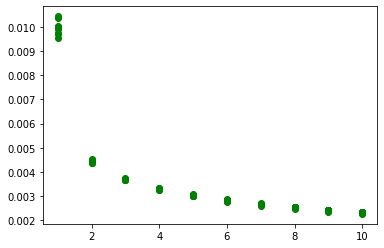

In [20]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU

#opti = customizerOP()

totalTestAcc=[]
for i in range(10):
  tf.random.set_seed(i+100)
  #test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu',use_l1=True,use_l2=True,use_cusOP=True)

  time_start = time.time()
  #temp opti but actually didnt use since cse_cusOP is set up True
  opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
  correct_test_prediction = tf.Variable(0, dtype=tf.float32)


  # Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    

    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, opti)

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
  #test_loss_total = 0.0
  # Validate model
  #for inputs, outputs in test_ds:
  #  preds = mlp_on_cpu.forward(inputs)
  #  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  #print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_cpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_test_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_test_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
  totalTestAcc.append(cur_test_acc)
  


In [21]:
totalTestAcc

[0.9599, 0.958, 0.9585, 0.9588, 0.9614, 0.9602, 0.959, 0.9586, 0.9594, 0.9571]


Train Accuracy: 0.8834
Number of Epoch = 1 - Average Cross Entropy:= 0.010011969604492188 

Validation Accuracy: 0.8957

Train Accuracy: 0.9171
Number of Epoch = 2 - Average Cross Entropy:= 0.0043715447998046875 

Validation Accuracy: 0.9265

Train Accuracy: 0.9318
Number of Epoch = 3 - Average Cross Entropy:= 0.0036703558349609373 

Validation Accuracy: 0.9389

Train Accuracy: 0.9401
Number of Epoch = 4 - Average Cross Entropy:= 0.003289407653808594 

Validation Accuracy: 0.9459

Train Accuracy: 0.9463
Number of Epoch = 5 - Average Cross Entropy:= 0.0030254318237304687 

Validation Accuracy: 0.9513

Train Accuracy: 0.9521
Number of Epoch = 6 - Average Cross Entropy:= 0.0028279641723632813 

Validation Accuracy: 0.9556

Train Accuracy: 0.9566
Number of Epoch = 7 - Average Cross Entropy:= 0.0026697747802734376 

Validation Accuracy: 0.9594

Train Accuracy: 0.9602
Number of Epoch = 8 - Average Cross Entropy:= 0.002541058807373047 

Validation Accuracy: 0.9618

Train Accuracy: 0.9632
Num

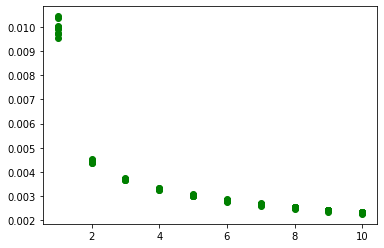

In [25]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU

#opti = customizerOP()

totalTestAcc_adam=[]
for i in range(10):
  tf.random.set_seed(i+100)
  #test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu',use_l1=True,use_l2=True)

  time_start = time.time()
  opti = tf.keras.optimizers.Adam(learning_rate = 1e-4)
  correct_test_prediction = tf.Variable(0, dtype=tf.float32)


  # Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    

    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, opti)

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
  #test_loss_total = 0.0
  # Validate model
  #for inputs, outputs in test_ds:
  #  preds = mlp_on_cpu.forward(inputs)
  #  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  #print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_cpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_test_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_test_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
  totalTestAcc_adam.append(cur_test_acc)
  


In [29]:
totalTestAcc_avg=np.mean(totalTestAcc)
var=np.var(totalTestAcc)
print(f"the test Acc_avg of custom optimizer is {totalTestAcc_avg}, and the variance is {var}")
print(f"the running time for custom optimizer is: {45} mins")

the test Acc_avg of custom optimizer is 0.9590900540351868, and the variance is 1.314899918725132e-06
the running time for custom optimizer is: 45 mins


In [31]:
totalTestAcc_adam_avg=np.mean(totalTestAcc_adam)
var=np.var(totalTestAcc_adam)
print(f"the test Acc_avg of custom optimizer is {totalTestAcc_adam_avg}, and the variance is {var}")
print(f"the running time for custom optimizer is: {31} mins")

the test Acc_avg of custom optimizer is 0.9590999484062195, and the variance is 1.4519907836074708e-06
the running time for custom optimizer is: 31 mins


In [ ]:
class customizerOP(object):
  def __init__(self, alpha=1e-3,beta1=0.9, beta2=0.999, beta3=0.999987, epslion=1e-8):
    self.alpha,self.beta_1, self.beta_2, self.beta_3, self.epslion =alpha,beta1, beta2, beta3, epslion
    self.m=[]
    self.v=[]
    self.u=[]
    self.t=0
  def apply_gradients(self,variables,grad):

    if self.t==0:
      for var in variables:
        self.m.append(tf.Variable(tf.zeros_like(var)))
        self.v.append(tf.Variable(tf.zeros_like(var)))
        self.u.append(tf.Variable(tf.zeros_like(var)))
      #self.m=tf.convert_to_tensor(self.m)
      #self.u=tf.convert_to_tensor(self.v)
      #self.u=tf.convert_to_tensor(self.u)
    #variables=tf.convert_to_tensor(variables)
    #grad=tf.convert_to_tensor(grad)


    self.t+=1
    new_var=[]
    for i in range(len(grad)):
      m = tf.math.add(tf.math.scalar_mul(self.beta_1, self.m[i]), tf.math.scalar_mul(1 - self.beta_1, grad[i]))
      self.m[i].assign(m)
      v = tf.math.add(tf.math.scalar_mul(self.beta_2, self.v[i]), tf.math.scalar_mul(1 - self.beta_2, tf.pow(grad[i],2.0)))
      self.v[i].assign(v)
      u = tf.math.add(tf.math.scalar_mul(self.beta_3, self.u[i]), tf.math.scalar_mul(1 - self.beta_3, tf.pow(grad[i],3.0)))
      self.u[i]=u

      mt = tf.math.divide(m, 1 - tf.pow(self.beta_1, self.t))
      vt = tf.math.divide(v, 1 - tf.pow(self.beta_2, self.t))
      ut = tf.math.divide(u, 1 - tf.pow(self.beta_3, self.t))
      
      vtRoot= tf.pow(vt, 1.0/2.0)
      utRoot= tf.math.multiply(tf.math.sign(ut), tf.math.pow(tf.abs(ut), 1.0/3.0))

      denominator = tf.math.add(tf.math.add(vtRoot, tf.math.scalar_mul(self.epslion, utRoot)), 1e-8)
      LRfactor = tf.math.divide(mt, denominator)
      new_var.append(variables[i]- tf.math.scalar_mul(self.alpha, LRfactor))

    return new_var

